In [131]:
import os
import json
import logging
import zarr
import s3fs
import fsspec
import geojson
import pyproj
import rioxarray
import pandas as pd
import geopandas as gpd
import awswrangler as wr
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import obstore as obs
import odc.geo.xr

from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon, mapping
from shapely.ops import transform as shp_transform
from rasterio.features import geometry_mask
from zarr.codecs.blosc import BloscCodec
from zarr.storage import ObjectStore
from obstore.store import S3Store, MemoryStore, from_url

In [2]:
REGION = "us-east-1"
DATABASE = "db_ice"
TABLE_POLIGONO = "tb_poligono"
TABLE_INGESTAO = "tb_controle_ingestao"
TABLE_CONTROLE_IMAGEM = "tb_controle_imagem"
TABLE_IMAGEM = "tb_imagem"
S3_BUCKET = "data-us-east-1-891377318910"
S3_PREFIX = "mvp_sensoriamento/images/sentinel-2-l2a"
S3_ATHENA_OUTPUT = "s3://aws-athena-query-results-891377318910-us-east-1/output/"

## Funcoes

In [3]:
def athena_read_sql(query: str) -> pd.DataFrame:
    return wr.athena.read_sql_query(
        sql=query,
        database=DATABASE,
        ctas_approach=False,
        s3_output=S3_ATHENA_OUTPUT
    )


def get_polygon_record_by_day(id_poligono: str) -> dict:
    # date_reference = datetime.today().strftime("%Y%m%d")
    query = f"""
    SELECT *
    FROM {DATABASE}.{TABLE_POLIGONO}
    WHERE id_poligono = '{id_poligono}'
    """
    df = athena_read_sql(query)
    try:
        return df.iloc[0, :].to_dict()
    except IndexError:
        return {}

In [4]:
def convert_polygon(polygon: str) -> Polygon:
    return wkt.loads(polygon)

## Poligono

In [5]:
id_poligono = "id_001"

In [6]:
record_polygon = get_polygon_record_by_day(id_poligono)

In [7]:
poligono = convert_polygon(record_polygon['poligono'])

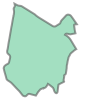

In [8]:
poligono

## Carregando zarr

In [9]:
prefix_poligono = f"{S3_PREFIX}/{id_poligono}.zarr"

s3_store = S3Store(bucket=S3_BUCKET, prefix=prefix_poligono, region=REGION, skip_signature=False)
zarr_store = ObjectStore(s3_store, read_only=True)

In [109]:
# https://docs.xarray.dev/en/stable/generated/xarray.open_zarr.html

ds = xr.open_zarr(
    store=zarr_store,
    consolidated=False,
    zarr_format=3,
    chunks={"time": 1},  # força chunking no tempo para streaming diário
)

In [110]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 166, y: 570, x: 418)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2023-05-21T13:18:59.470000 ... 202...
  * x            (x) float64 3kB 3.383e+05 3.383e+05 ... 3.424e+05 3.425e+05
  * y            (y) float64 5kB 7.389e+06 7.389e+06 ... 7.384e+06 7.384e+06
Data variables: (12/13)
    blue         (time, y, x) uint16 79MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    green        (time, y, x) uint16 79MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    red          (time, y, x) uint16 79MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    spatial_ref  int32 4B ...
    nir          (time, y, x) uint16 79MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    rededge2     (time, y, x) uint16 79MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    ...           ...
    rededge1     (time, y, x) uint16 79MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    nir08        (time, y, x) uint16 79MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    rededge3     (time, y, x) uint16 79MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    swir16       (time, y, x) uint16 79MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    ndvi         (time, y, x) float64 316MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    swir22       (time, y, x) uint16 79MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>

In [129]:
# dir(ds.odc.crs)
ds_crs = ds.odc.crs.crs_str

In [27]:
# ds.odc.geobox

In [145]:
# polygon_mask = geometry_mask(
#     [poligono],
#     transform=ds.odc.geobox.transform,
#     invert=True,
#     out_shape=(ds.odc.geobox.height, ds.odc.geobox.width),
# )


crs_ds = ds.odc.crs
project = pyproj.Transformer.from_crs(ds_crs, crs_ds, always_xy=True).transform
poly_proj = shp_transform(project, poligono)

ds_gb = ds.odc.geobox
mask_np = geometry_mask(
    [mapping(poly_proj)],
    transform=ds_gb.transform,
    out_shape=(ds_gb.height, ds_gb.width),
    invert=True,
)

vis = ds.odc.to_rgba(bands=("red", "green", "blue"), vmin=0, vmax=3000)
spatial_dims = [d for d in vis.dims if d not in ("time", "band")]
y_dim, x_dim = spatial_dims
mask = xr.DataArray(
    mask_np,
    dims=(y_dim, x_dim),
    coords={y_dim: ds.coords[y_dim], x_dim: ds.coords[x_dim]},
)

In [146]:
ds_masked = ds.where(mask)

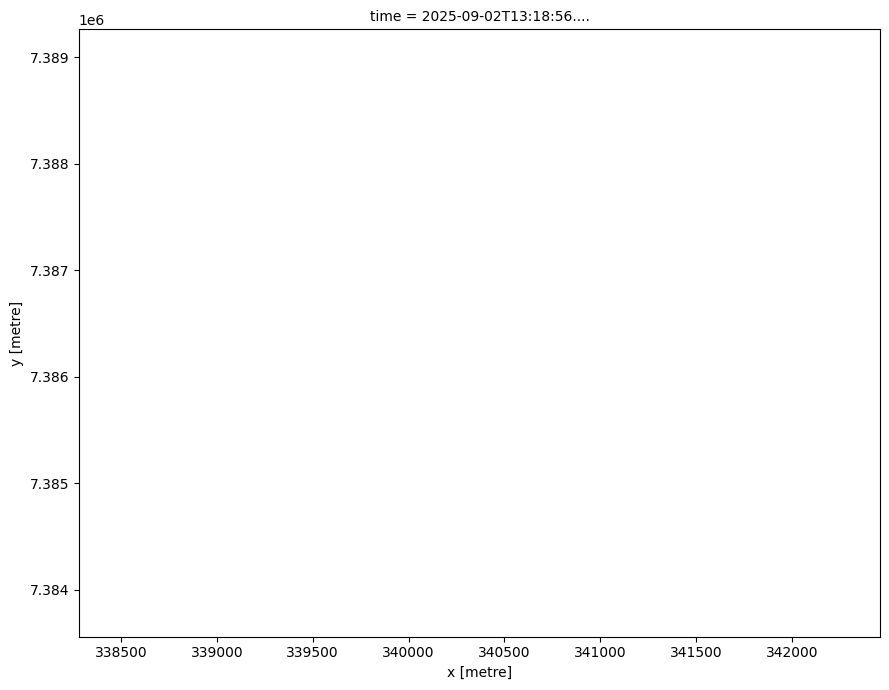

In [151]:
ds2 = ds_masked.sel(time="2025-09-02")
vis = ds2.odc.to_rgba(bands=("red", "green", "blue"), vmin=0, vmax=3000)
vis.plot.imshow(figsize=(9, 7), col='time', rgb='band', robust=True)
plt.show()

In [28]:
ds2 = ds.sel(time="2025-09-02")

In [85]:
# ds2['red'].plot.hist(figsize=(10, 5))
# plt.show()

In [ ]:
# https://docs.xarray.dev/en/stable/generated/xarray.DataArray.plot.imshow.html

# vis = ds2.odc.to_rgba(bands=("red", "green", "blue"), vmin=0, vmax=3000)
# vis.plot.imshow(figsize=(9, 7), col='time', rgb='band', robust=True)
# plt.show()

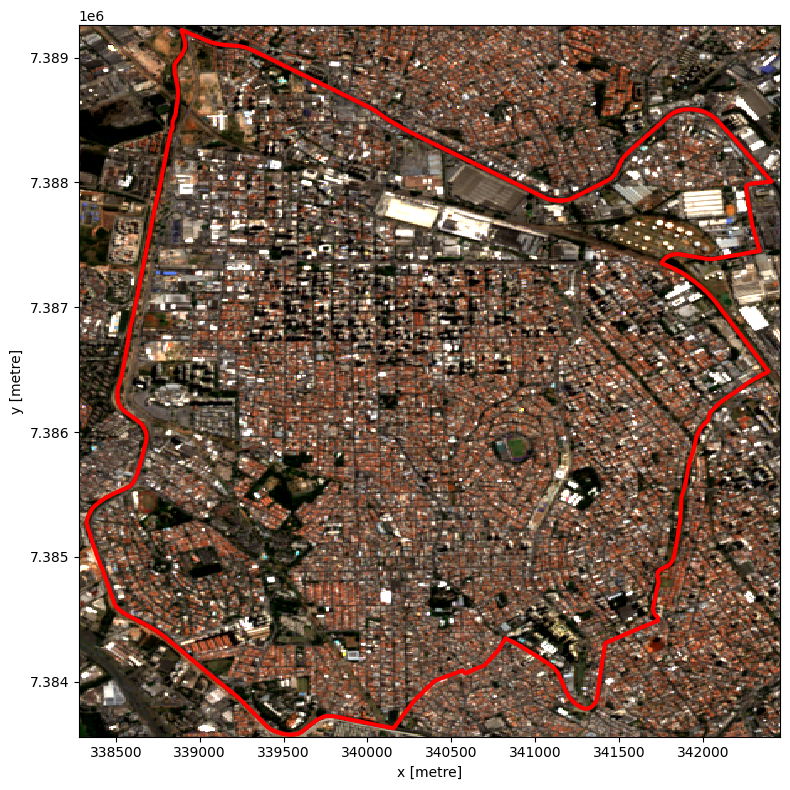

In [99]:
vis = ds2.odc.to_rgba(bands=("red", "green", "blue"), vmin=0, vmax=3000)
vis = vis.squeeze("time", drop=True)
fig, ax = plt.subplots(figsize=(8, 8))

crs_ds = ds.odc.crs
project = pyproj.Transformer.from_crs("EPSG:4326", crs_ds, always_xy=True).transform
poly_proj = shp_transform(project, poligono)

# x, y = poly_proj.exterior.xy
# ax.plot(x, y, color="red", linewidth=2)
geoms = getattr(poly_proj, "geoms", [poly_proj])
for g in geoms:
    x, y = g.exterior.xy
    ax.plot(x, y, color="red", linewidth=3)

vis.plot.imshow(ax=ax, rgb='band', robust=True)

plt.tight_layout()
plt.show()